In [114]:
import json
import os
import pickle
import statistics

from matplotlib import pyplot as plt
from scipy.stats import norm, t

from utils import average_server, average_simulation


In [115]:
test_number = 1

In [116]:
average = average_simulation()

average

{'loss': [14.233338197072348,
  12.23792854944865,
  10.87703227996826,
  9.906468073527018,
  9.182672341664633,
  8.620261033376059,
  8.167656580607096,
  7.793057123819987,
  7.476325352986653,
  7.2042873700459795,
  6.967992305755616,
  6.761095603307088,
  6.5789151191711435,
  6.4178517659505205,
  6.275044759114583,
  6.1481560071309405,
  6.035231192906697,
  5.934612035751343,
  5.844868818918864,
  5.7647651831309,
  5.6932181517283125,
  5.629278898239136,
  5.572110652923584,
  5.5209751923878985,
  5.475219170252482,
  5.434262752532959,
  5.397591272989909,
  5.364747603734335,
  5.335325241088867,
  5.308960914611816,
  5.285333077112834,
  5.264152685801188,
  5.245163520177205,
  5.228136062622071,
  5.212864716847738,
  5.199167013168335,
  5.1868791580200195,
  5.175854603449504,
  5.165961980819702,
  5.157085259755452,
  5.149118343989055,
  5.141968011856079,
  5.135549783706665,
  5.129788080851236,
  5.12461535135905,
  5.11997111638387,
  5.115801652272542,
 

In [117]:
min(average['loss'])

5.079116980234782

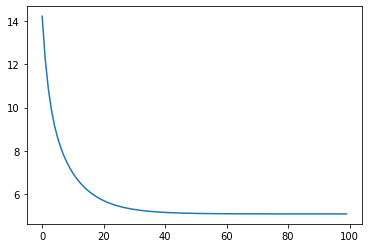

In [118]:
plt.plot(average['loss'])
plt.show()

In [119]:
server_average = average_server()
server_average['server_loss'] = server_average.pop('loss')

with open(f'tests_average/test{test_number}.json', 'w+') as output:
    json.dump([average, server_average], output)
    test_number += 1

server_average

{'server_loss': [19.026809692382812,
  18.15441068013509,
  17.742680549621582,
  17.62696139017741,
  17.70618120829264,
  17.91681448618571,
  18.21779505411784,
  18.581716537475586,
  18.989639282226562,
  19.428030331929527,
  19.886906623840336,
  20.358702659606937,
  20.837558110555012,
  21.318865140279136,
  21.798956553141274,
  22.27490552266439,
  22.74436855316162,
  23.205480575561523,
  23.65676275889079,
  24.09707037607829,
  24.525502840677895,
  24.941410700480144,
  25.344327608744305,
  25.733943303426106,
  26.11007308959961,
  26.47266133626302,
  26.821729977925617,
  27.157382329305015,
  27.479783058166507,
  27.789157231648762,
  28.085760752360027,
  28.369889577229817,
  28.64185905456543,
  28.902016639709473,
  29.150714556376137,
  29.388318061828613,
  29.615201632181805,
  29.831739743550617,
  30.038306554158527,
  30.235275586446125,
  30.42301654815674,
  30.601903279622395,
  30.77228895823161,
  30.93452262878418,
  31.08894983927409,
  31.235906

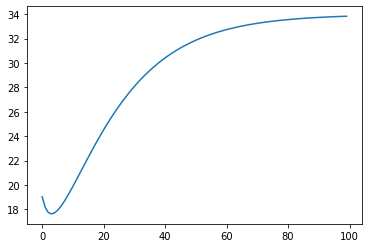

In [120]:
plt.plot(server_average['server_loss'])
plt.show()

In [121]:
with open('simulation/client0', 'rb') as input:
    data = pickle.load(input)

len(data)

1

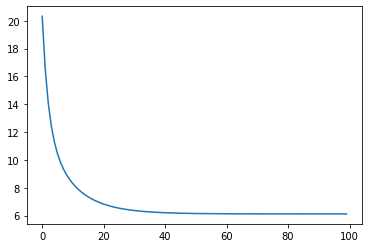

In [122]:
for i in data:
    plt.plot(i['loss'])

plt.show()

In [123]:
d = [i for i in os.listdir('simulation') if not i.startswith('.')]
all_data = {}
for file in d:
    with open(os.path.join('simulation', file), 'rb') as input:
        data = pickle.load(input)
        for iteration in data:
            for round_num in range(len(iteration['loss'])):
                if round_num not in all_data.keys():
                    all_data[round_num] = []
                all_data[round_num].append(iteration['loss'][round_num])

In [124]:
# for key, d in all_data.items():
#     mean = statistics.mean(d)
#     sd = statistics.stdev(d)

#     print(f'mean = {mean}')
#     print(f'standard deviation = {sd}')

#     plt.scatter(d, norm.pdf(d, mean, sd))
#     # plt.scatter(d, t.pdf(d, mean, sd), color = 'r')
#     plt.show()